In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
import bisect

## 1. Reading Data

In [3]:
df = pd.read_csv("data/bmw_pricing_challenge.csv")

In [4]:
df.head()

,maker_key,model_key,mileage,engine_power,registration_date,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,sold_at
0,BMW,118,140411,100,2012-02-01,diesel,black,convertible,True,True,False,False,True,True,True,False,11300,2018-01-01
1,BMW,M4,13929,317,2016-04-01,petrol,grey,convertible,True,True,False,False,False,True,True,True,69700,2018-02-01
2,BMW,320,183297,120,2012-04-01,diesel,white,convertible,False,False,False,False,True,False,True,False,10200,2018-02-01
3,BMW,420,128035,135,2014-07-01,diesel,red,convertible,True,True,False,False,True,True,True,True,25100,2018-02-01
4,BMW,425,97097,160,2014-12-01,diesel,silver,convertible,True,True,False,False,False,True,True,True,33400,2018-04-01


In [5]:
df.shape

(4843, 18)

In [6]:
df.describe()

,mileage,engine_power,price
count,4.843000e+03,4843.00000,4843.000000
mean,1.409628e+05,128.98823,15828.081767
std,6.019674e+04,38.99336,9220.285684
min,-6.400000e+01,0.00000,100.000000
25%,1.029135e+05,100.00000,10800.000000
50%,1.410800e+05,120.00000,14200.000000
75%,1.751955e+05,135.00000,18600.000000
max,1.000376e+06,423.00000,178500.000000


In [7]:
df = df[df["mileage"] > 0]
df = df[df["engine_power"] >0]

In [8]:
df['registration_date'] = pd.to_datetime(df['registration_date'])
df['sold_at'] = pd.to_datetime(df['sold_at'])

## 2. Exploratory Data Analysis

### 2.1. Missing Values

In [9]:
df.isna().sum()

maker_key            0
model_key            0
mileage              0
engine_power         0
registration_date    0
fuel                 0
paint_color          0
car_type             0
feature_1            0
feature_2            0
feature_3            0
feature_4            0
feature_5            0
feature_6            0
feature_7            0
feature_8            0
price                0
sold_at              0
dtype: int64

### 2.2. Distribution of the target variable 

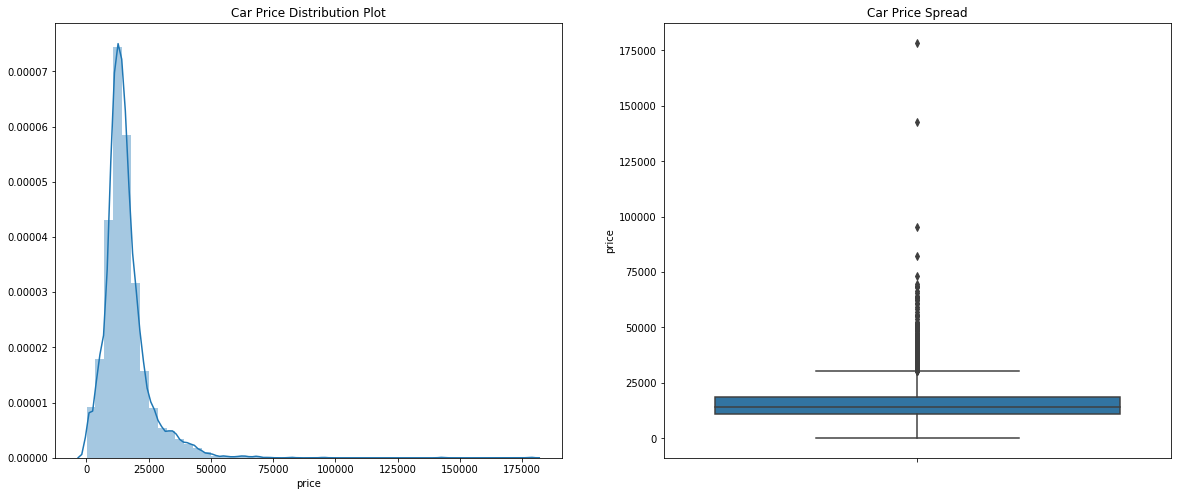

In [10]:
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.title('Car Price Distribution Plot')
sns.distplot(df.price)

plt.subplot(1,2,2)
plt.title('Car Price Spread')
sns.boxplot(y=df.price)

plt.show()

### 2.3. Numerical Variables

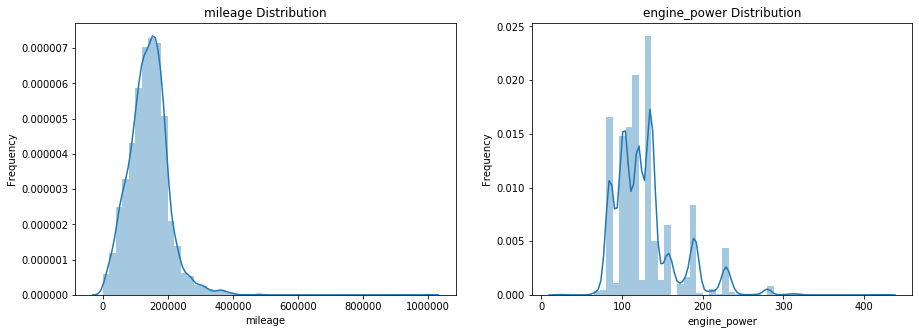

In [11]:
num_cols = ['mileage', 'engine_power']
fig_rows = np.ceil(len(num_cols)/2)

plt.figure(figsize=(15, fig_rows*5))
plt.subplots_adjust(hspace=0.5)

for ind, col in enumerate(num_cols):
    plt.subplot(fig_rows,2,ind+1)
    plt.title(col+' Distribution')
    ax = sns.distplot(df[col])
    ax.set(xlabel = col, ylabel='Frequency')

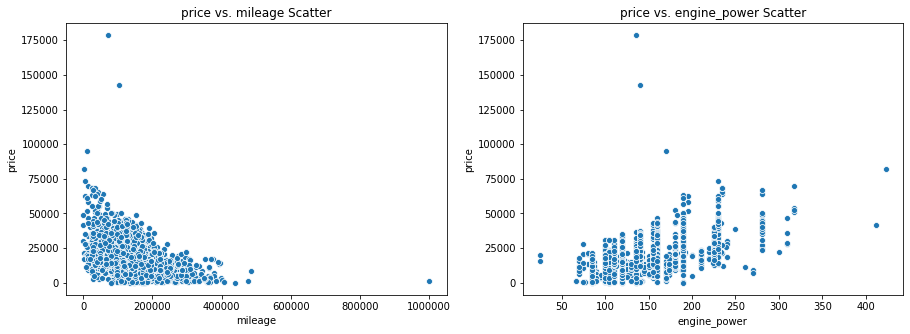

In [12]:
num_cols = ['mileage', 'engine_power']
fig_rows = np.ceil(len(num_cols)/2)

plt.figure(figsize=(15, fig_rows*5))
plt.subplots_adjust(hspace=0.5)

for ind, col in enumerate(num_cols):
    plt.subplot(fig_rows,2,ind+1)
    plt.title('price vs. '+col+' Scatter')
    ax = sns.scatterplot(x=df[col],y=df["price"])
    ax.set(xlabel = col, ylabel='price')

### 2.4. Catagorical Variables

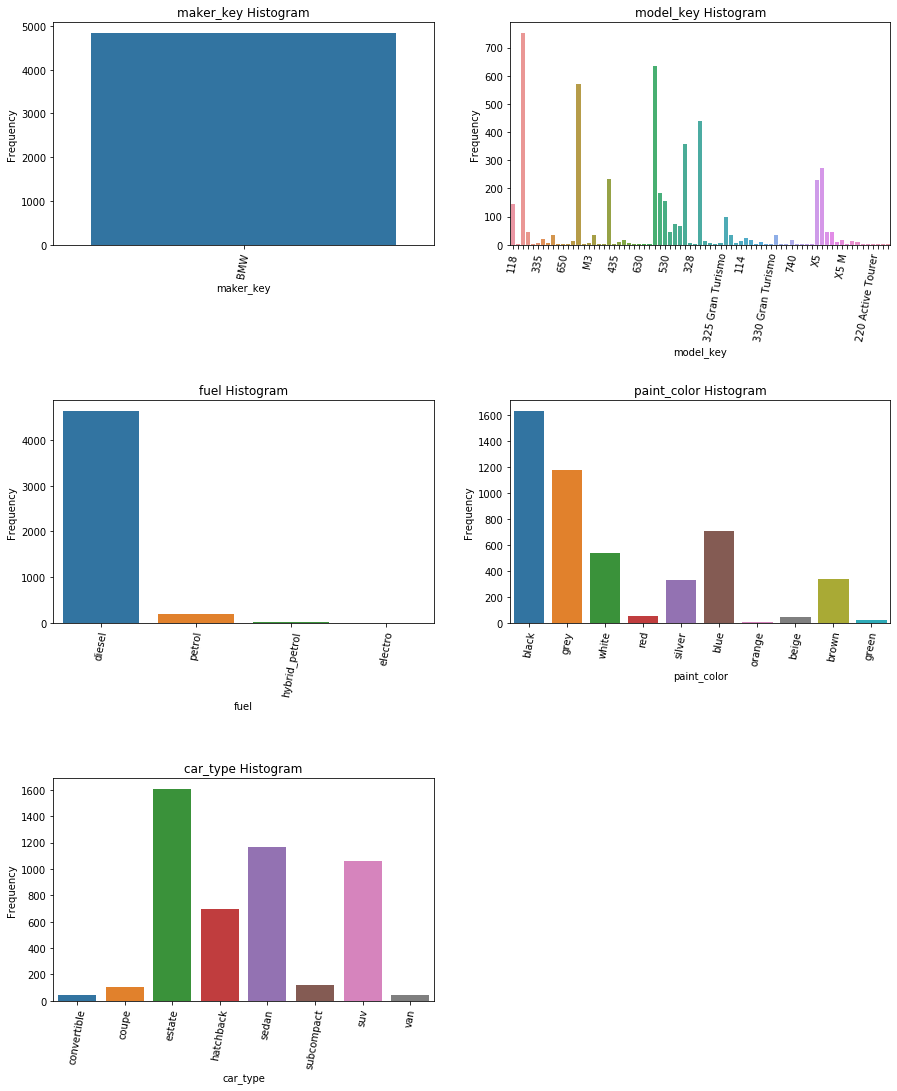

In [13]:
cat_cols = ['maker_key', 'model_key', 'fuel', 'paint_color', 'car_type']
fig_rows = np.ceil(len(cat_cols)/2)

plt.figure(figsize=(15, fig_rows*6))
plt.subplots_adjust(hspace=0.7)

for ind, col in enumerate(cat_cols):
    plt.subplot(fig_rows,2,ind+1)
    plt.title(col+' Histogram')
    ax = sns.countplot(df[col])
    ax.set(xlabel = col, ylabel='Frequency')
    xtickslabels=ax.get_xticklabels()
    ax.set_xticklabels(xtickslabels, rotation=80)
    # reduce number of ticks when too many
    if(len(xtickslabels)>20):
        for ind, label in enumerate(xtickslabels):
            if ind % 5 == 0:  # every 10th label is kept
                label.set_visible(True)
            else:
                label.set_visible(False)

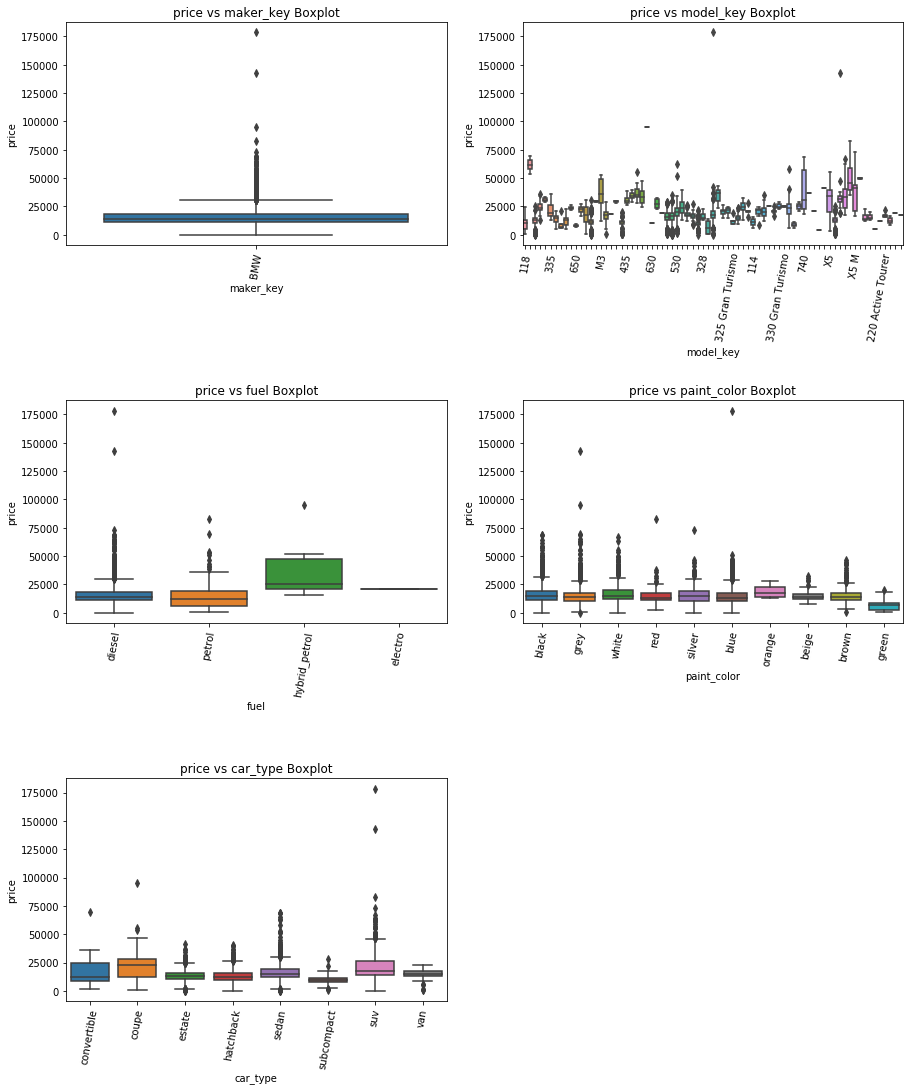

In [14]:
cat_cols = ['maker_key', 'model_key', 'fuel', 'paint_color', 'car_type']
fig_rows = np.ceil(len(cat_cols)/2)

plt.figure(figsize=(15, fig_rows*6))
plt.subplots_adjust(hspace=0.7)

for ind, col in enumerate(cat_cols):
    plt.subplot(fig_rows,2,ind+1)
    plt.title('price vs ' +col+' Boxplot')
    ax = sns.boxplot(x=df[col], y=df["price"])
    ax.set(xlabel = col, ylabel='price')
    xtickslabels=ax.get_xticklabels()
    ax.set_xticklabels(xtickslabels, rotation=80)
    # reduce number of ticks when too many
    if(len(xtickslabels)>20):
        for ind, label in enumerate(xtickslabels):
            if ind % 5 == 0:  # every 10th label is kept
                label.set_visible(True)
            else:
                label.set_visible(False)

### 2.5. Dates

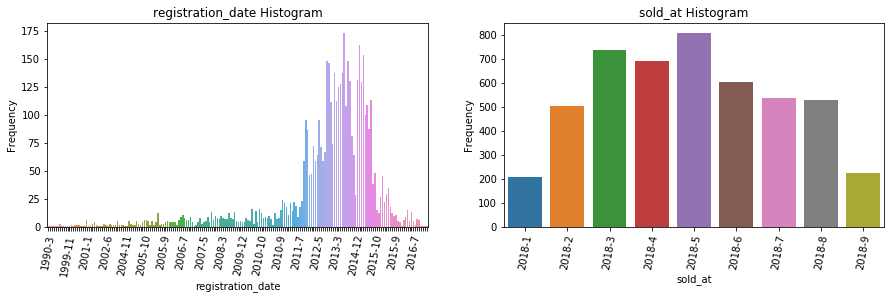

In [15]:
dates_cols = ['registration_date', 'sold_at']
fig_rows = np.ceil(len(cat_cols)/2)

plt.figure(figsize=(15, fig_rows*5))
plt.subplots_adjust(hspace=0.5)

for ind, col in enumerate(dates_cols):
    plt.subplot(fig_rows,2,ind+1)
    plt.title(col+' Histogram')
    ax = sns.countplot((df[col].dt.year.astype(str) + '-' + df[col].dt.month.astype(str)).sort_values())
    ax.set(xlabel = col, ylabel='Frequency')
    xtickslabels=ax.get_xticklabels()
    ax.set_xticklabels(xtickslabels, rotation=80)
    # reduce number of ticks when too many
    if(len(xtickslabels)>20):
        for ind, label in enumerate(xtickslabels):
            if ind % 10 == 0:  # every 10th label is kept
                label.set_visible(True)
            else:
                label.set_visible(False)

## 3. Data Splitting

In [16]:
y = df.pop("price")
X = df

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=8)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3388, 17)
(3388,)
(1453, 17)
(1453,)


## 4. Feature Engineering

### 4.1. Removing non-predictive features

In [18]:
X_train.drop('maker_key', axis=1, inplace=True)
X_test.drop('maker_key', axis=1, inplace=True)

### 4.2. Creating new features

#### Adding feature 'vehicle age'

In [19]:
X_train['age'] = (X_train['sold_at'] -  X_train['registration_date'])/ np.timedelta64(1, 'Y')
X_test['age'] = (X_test['sold_at'] -  X_test['registration_date'])/ np.timedelta64(1, 'Y')

[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'age')]

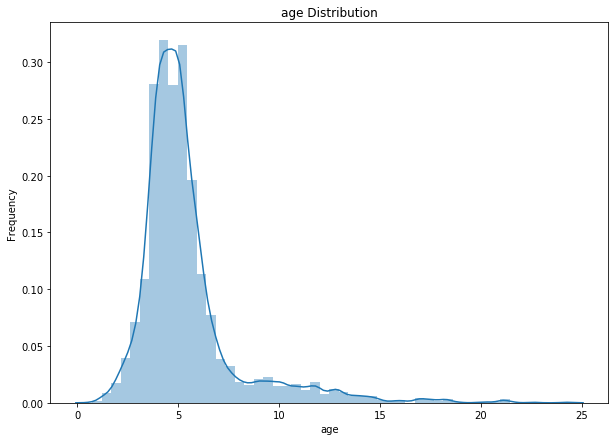

In [20]:
plt.figure(figsize=(10, 7))

plt.title('age Distribution')
ax = sns.distplot(X_train['age'])
ax.set(xlabel = 'age', ylabel='Frequency')

In [21]:
X_train.drop('sold_at', axis=1, inplace=True)
X_test.drop('sold_at', axis=1, inplace=True)
X_train.drop('registration_date', axis=1, inplace=True)
X_test.drop('registration_date', axis=1, inplace=True)

#### Creating polynomial features for numerical columns

In [22]:
num_cols = ['mileage', 'engine_power', 'age']

PF = PolynomialFeatures(degree=4, include_bias=False)

# Encode categorical columns, and store results in a new dataframe
X_train_poly = pd.DataFrame(PF.fit_transform(X_train[num_cols]), index=X_train.index)
X_test_poly = pd.DataFrame(PF.transform(X_test[num_cols]), index=X_test.index)

# Adding poly columns to initial datasets
poly_feature_names = PF.get_feature_names()
replace_dict = {"x"+str(i):num_cols[i] for i in range(3)}

for ind, name in replace_dict.items():
    poly_feature_names = [w.replace(ind, name) for w in poly_feature_names]
X_train_poly.columns = poly_feature_names
X_test_poly.columns = poly_feature_names

# Drop initial columns 
X_train.drop(num_cols ,axis=1, inplace=True)
X_test.drop(num_cols ,axis=1, inplace=True)
num_cols = poly_feature_names

# Add feature engineered columns to initial dataset
X_train = pd.concat([X_train, X_train_poly], axis=1)
X_test = pd.concat([X_test, X_test_poly ], axis=1) 

In [23]:
#num_cols = ['mileage', 'engine_power', 'age']

#for col in num_cols:
#    X_train[col+'2'] = X_train[col]**2
#    X_test[col+'2'] = X_test[col]**2
#    X_train[col+'3'] = X_train[col]**3
#    X_test[col+'3'] = X_test[col]**3

### 4.3. Scaling numerical variables

In [24]:
SS = StandardScaler()
scaled_cols = num_cols 

X_train[scaled_cols] = SS.fit_transform(X_train[scaled_cols])
X_test[scaled_cols] = SS.transform(X_test[scaled_cols])

### 4.4. Label encoding

In [25]:
set(X_test['model_key'])-set(X_train['model_key'])

{'220 Active Tourer', '225', '225 Active Tourer', '630'}

In [26]:
LE = LabelEncoder()
le_cols = [] 

for col in le_cols:
    # fit transform the training set
    X_train[col] = LE.fit_transform(X_train[col])

    # transform the test set
    X_test[col] = X_test[col].map(lambda s: 'other' if s not in LE.classes_ else s)
    le_classes = LE.classes_.tolist()
    bisect.insort_left(le_classes, 'other')
    LE.classes_ = le_classes

    X_test[col] = LE.transform(X_test[col])

### 4.5. One-hot encoding

In [27]:
OHE = OneHotEncoder(drop = None, handle_unknown='ignore', sparse=False)

# Define categorical to be one hot encoded
ohe_cols = ["paint_color", "car_type", "fuel"] + ["model_key"]

# Encode categorical columns, and store results in a new dataframe
X_train_encoded = pd.DataFrame(OHE.fit_transform(X_train[ohe_cols]), index=X_train.index)
X_test_encoded = pd.DataFrame(OHE.transform(X_test[ohe_cols]), index=X_test.index)

# Retrieve encoded columns names
X_train_encoded.columns = OHE.get_feature_names(ohe_cols)
X_test_encoded.columns = OHE.get_feature_names(ohe_cols)

# Drop initial columns 
X_train.drop(ohe_cols ,axis=1, inplace=True)
X_test.drop(ohe_cols ,axis=1, inplace=True)

# Add encoded columns to initial dataset
X_train = pd.concat([X_train, X_train_encoded], axis=1)
X_test = pd.concat([X_test, X_test_encoded ], axis=1)

### 4.6. Converting boolean columns

In [28]:
bool_cols = ['feature_' + str(i) for i in np.arange(1,9)]
X_train[bool_cols] = X_train[bool_cols].astype(int)
X_test[bool_cols] = X_test[bool_cols].astype(int)

## 5. Correlations

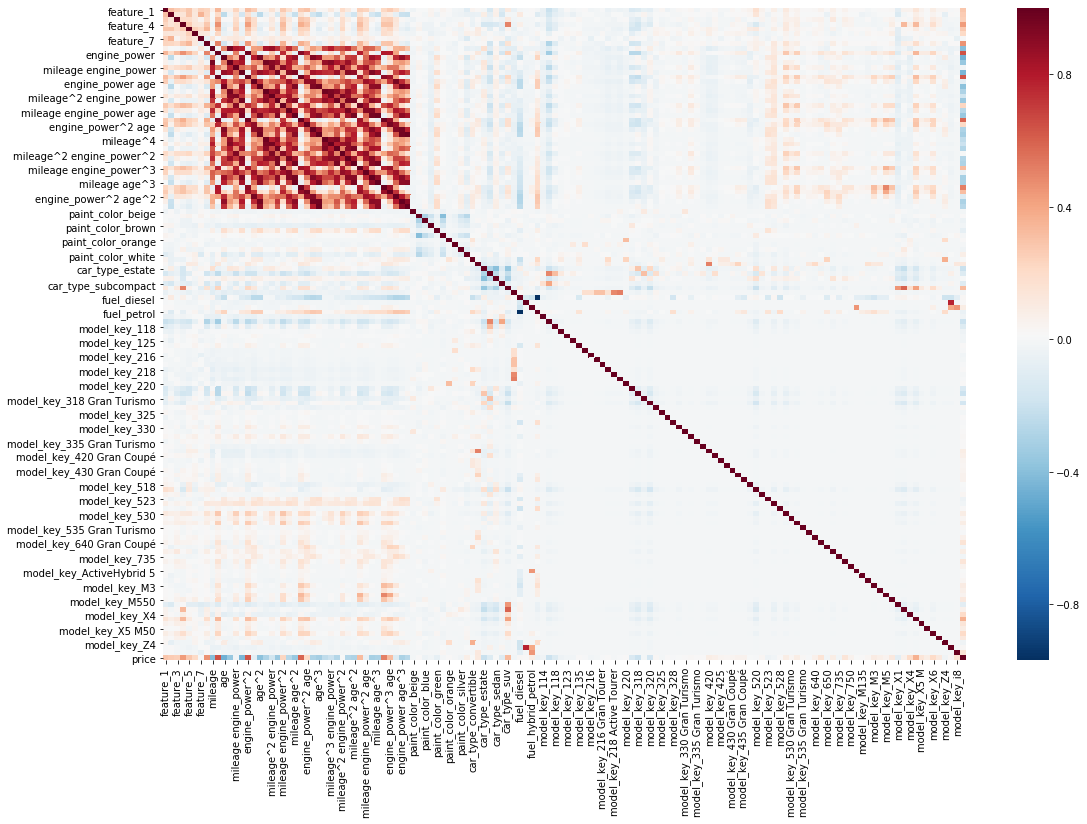

In [29]:
df_engineered = X_train.copy()
df_engineered['price'] = y_train

dfcorr = df_engineered.corr()

plt.subplots(figsize=(18, 12))
sns.heatmap(dfcorr, cmap="RdBu_r")

Note: Not all features are displayed!

## 6. Linear Regression

In [30]:
# fit linear model
lr = LinearRegression()
lr.fit(X_train, y_train)

# predicting over training & testing datasets
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

In [31]:
rmse = (np.sqrt(mean_squared_error(y_train, y_train_pred)))
r2 = r2_score(y_train, y_train_pred)

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set
rmse = (np.sqrt(mean_squared_error(y_test, y_test_pred)))
r2 = r2_score(y_test, y_test_pred)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance for training set
--------------------------------------
RMSE is 3386.8003028756293
R2 score is 0.8543161454275495


The model performance for testing set
--------------------------------------
RMSE is 5523.789496978208
R2 score is 0.6863379852122243


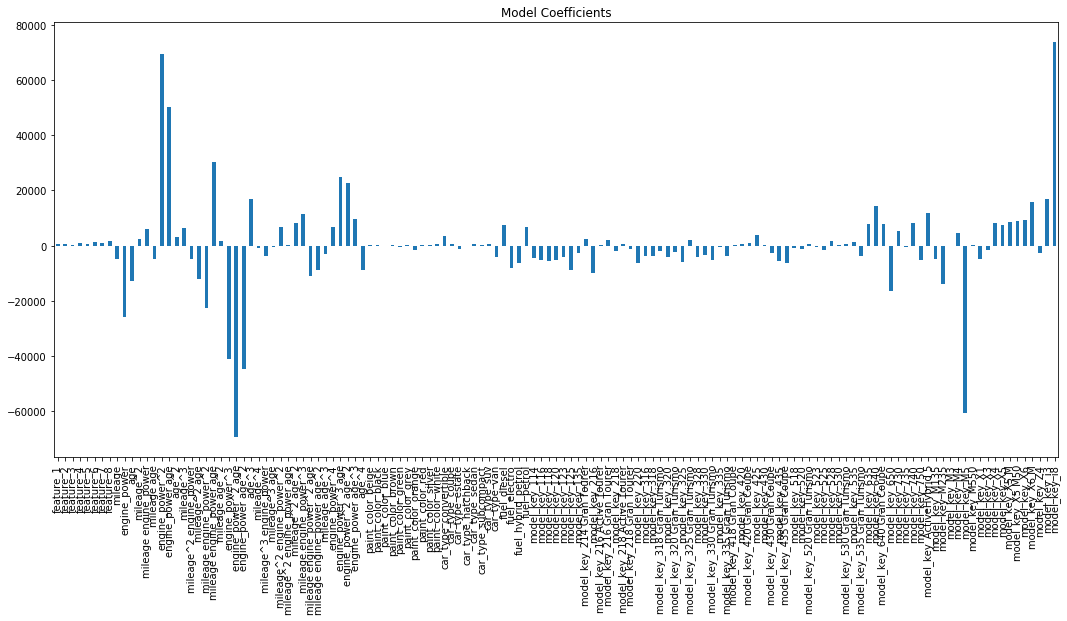

In [32]:
coef = pd.Series(lr.coef_, X_train.columns)

plt.figure(figsize=(18, 8))
coef.plot(kind='bar', title='Model Coefficients')

## 7. Ridge

In [33]:
ridge = RidgeCV(alphas=[10**i for i in np.arange(-4, 4,  0.2, dtype=float)], scoring='r2', cv=5)

ridge.fit(X_train, y_train)

# predicting over training & testing datasets
y_train_pred = ridge.predict(X_train)
y_test_pred = ridge.predict(X_test)

This is equivalent to:

In [34]:
## training the model
param_grid = {'alpha': [10**i for i in np.arange(-4, 4,  0.2, dtype=float)]}

ridge = Ridge(normalize=False)
ridge_search = GridSearchCV(ridge, param_grid, scoring='r2', cv=5)
ridge_search.fit(X_train, y_train)

# predicting over training & testing datasets
y_train_pred = ridge_search.predict(X_train)
y_test_pred = ridge_search.predict(X_test)

In [35]:
ridge_search.best_estimator_

Ridge(alpha=0.6309573444801981, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [36]:
# model evaluation for training set
rmse = (np.sqrt(mean_squared_error(y_train, y_train_pred)))
r2 = r2_score(y_train, y_train_pred)

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set
rmse = (np.sqrt(mean_squared_error(y_test, y_test_pred)))
r2 = r2_score(y_test, y_test_pred)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance for training set
--------------------------------------
RMSE is 3452.764881763716
R2 score is 0.8485859223275528


The model performance for testing set
--------------------------------------
RMSE is 5250.811747183621
R2 score is 0.7165734148207263


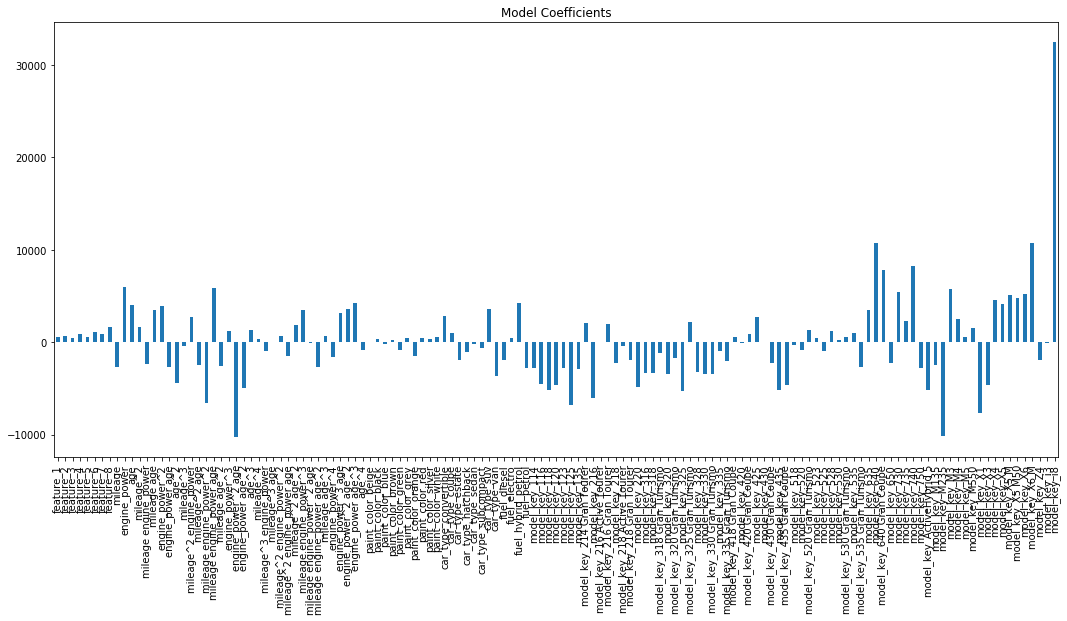

In [37]:
coef = pd.Series(ridge_search.best_estimator_.coef_, X_train.columns)

plt.figure(figsize=(18, 8))
coef.plot(kind='bar', title='Model Coefficients')

### Predictions vs. Actual for Ridge:

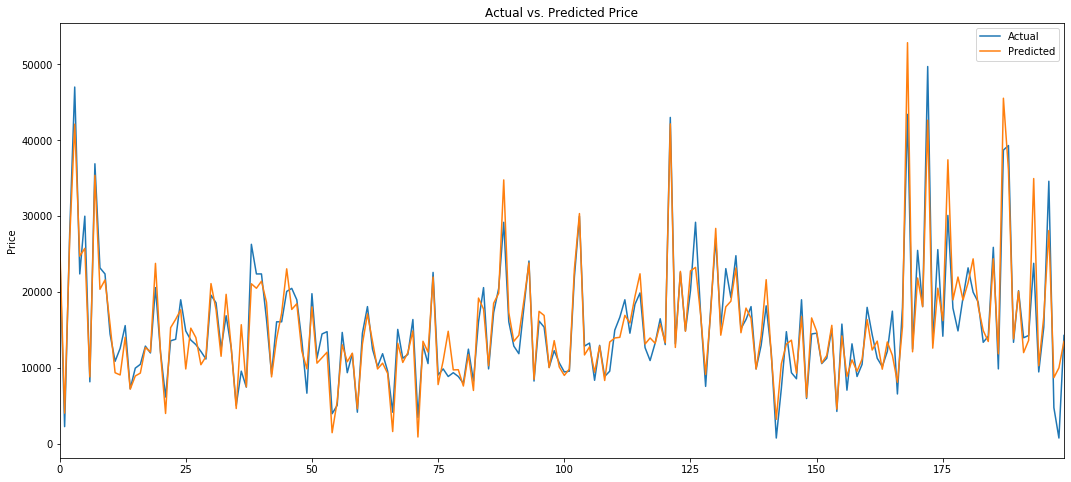

In [38]:
predictions = pd.DataFrame({"Actual": y_test, "Predicted": y_test_pred})
# plot a sample of observations
predictions = predictions.sample(n=200)
predictions = predictions.sort_index().reset_index()

plt.figure(figsize=(18, 8))
predictions['Actual'].plot(legend=True)
predictions['Predicted'].plot(legend=True)
plt.title('Actual vs. Predicted Price')
plt.ylabel('Price')
plt.show()

## 8. Lasso

In [39]:
## training the model
param_grid = {'alpha': [10**i for i in np.arange(-4, 4,  0.2, dtype=float)]}

lasso = Lasso(normalize=False)
lasso_search = GridSearchCV(lasso, param_grid, scoring='r2', cv=5)
lasso_search.fit(X_train, y_train)

# predicting over training & testing datasets
y_train_pred = lasso_search.predict(X_train)
y_test_pred = lasso_search.predict(X_test)

In [40]:
lasso_search.best_estimator_

Lasso(alpha=1.0000000000000082, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [41]:
# model evaluation for training set
rmse = (np.sqrt(mean_squared_error(y_train, y_train_pred)))
r2 = r2_score(y_train, y_train_pred)

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set
rmse = (np.sqrt(mean_squared_error(y_test, y_test_pred)))
r2 = r2_score(y_test, y_test_pred)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance for training set
--------------------------------------
RMSE is 3446.3101938030327
R2 score is 0.8491515079576754


The model performance for testing set
--------------------------------------
RMSE is 6230.3814328295675
R2 score is 0.6009595154816683


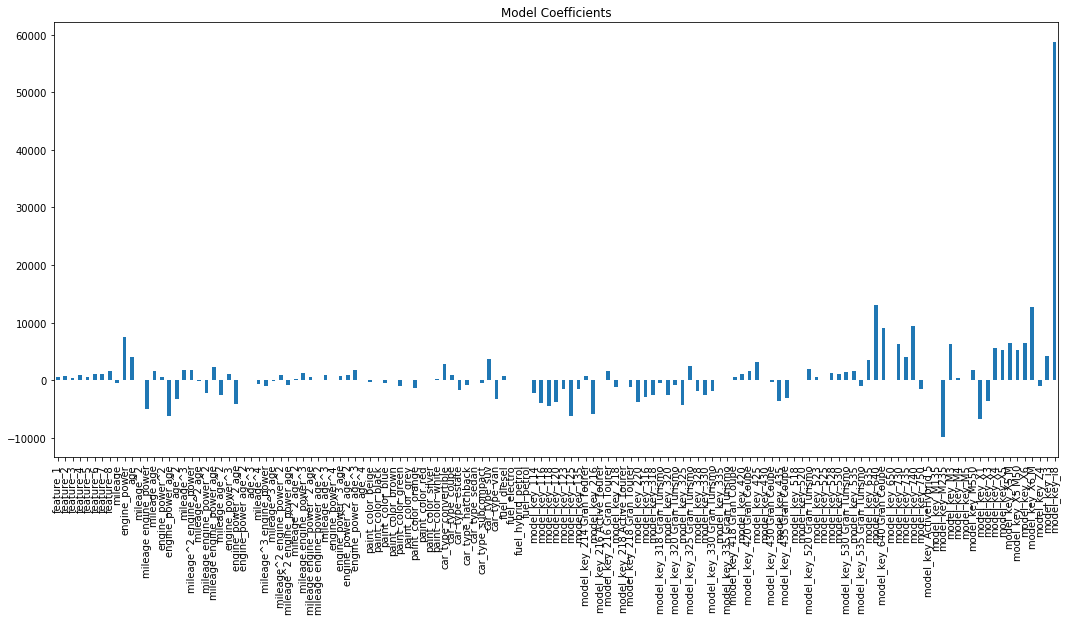

In [42]:
coef = pd.Series(lasso_search.best_estimator_.coef_, X_train.columns)

plt.figure(figsize=(18, 8))
coef.plot(kind='bar', title='Model Coefficients')

## Optional:

## 9. Random Forest Regressor

In [43]:
X_train.drop([x for x in poly_feature_names if x not in ['mileage', 'age', 'engine_power']], axis=1, inplace=True)
X_test.drop([x for x in poly_feature_names if x not in ['mileage', 'age', 'engine_power']], axis=1, inplace=True)

In [44]:
# Create the random grid
random_grid = { # Number of trees in random forest
               'n_estimators': [int(x) for x in np.linspace(start = 50, stop = 400, num = 8)],
                # Number of features to consider at every split
               'max_features': ['auto', 'sqrt', 'log2'],
                # Maximum number of levels in tree
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)] + [None],
                # Minimum number of samples required to split a node
               'min_samples_split': [2, 5, 10],
                # Minimum number of samples required at each leaf node
               'min_samples_leaf': [1, 2, 4],
                # Method of selecting samples for training each tree
               'bootstrap': [True, False]}

print(random_grid)
rf = RandomForestRegressor(criterion="mse", random_state=0)
rf_search = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=1, random_state=0)
rf_search = rf_search.fit(X_train, y_train)

{'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  7.1min finished


In [45]:
rf_search.best_params_

{'n_estimators': 300,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 80,
 'bootstrap': True}

In [46]:
# predicting over training & testing datasets
y_train_pred = rf_search.predict(X_train)
y_test_pred = rf_search.predict(X_test)

In [47]:
# model evaluation for training set
rmse = (np.sqrt(mean_squared_error(y_train, y_train_pred)))
r2 = r2_score(y_train, y_train_pred)

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set
rmse = (np.sqrt(mean_squared_error(y_test, y_test_pred)))
r2 = r2_score(y_test, y_test_pred)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance for training set
--------------------------------------
RMSE is 1788.2866403760245
R2 score is 0.9593831248460093


The model performance for testing set
--------------------------------------
RMSE is 5099.136599436387
R2 score is 0.7327110650020864


#### Feature Importance

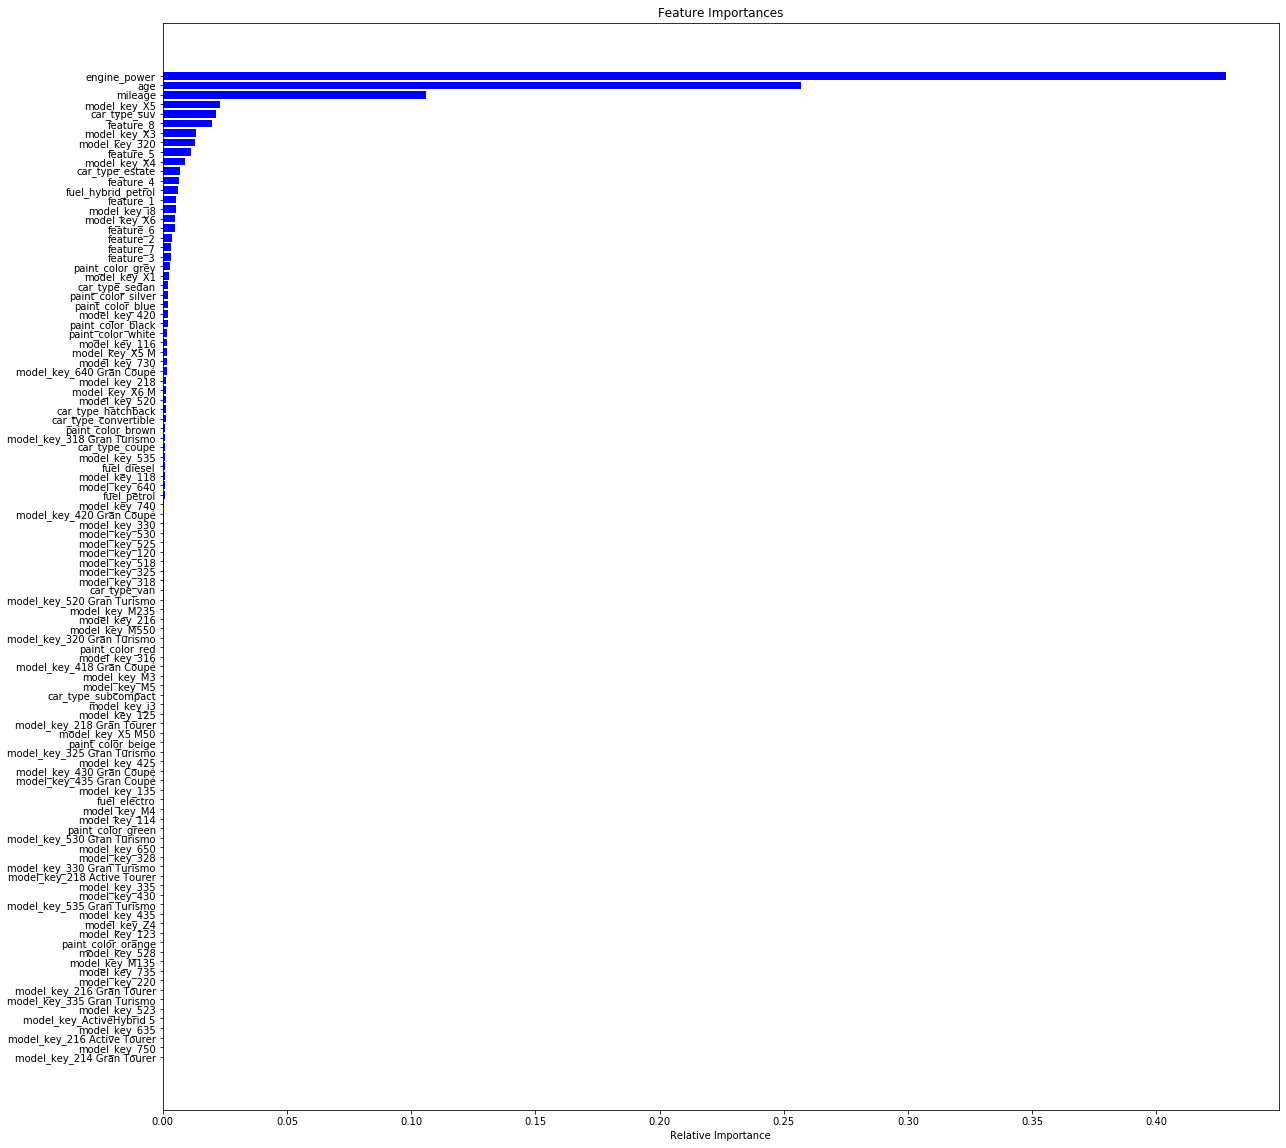

In [48]:
features = X_train.columns
importances = rf_search.best_estimator_.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(20, 20))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## 10. Gradient Boost Regressor

In [49]:
X_train.max().max()

7.373741218011459

In [50]:
param_grid = {"max_features": ["log2"],
              "max_depth": [5],
              "n_estimators": [300],
              "min_samples_split" : [7],
              'alpha': [10**i for i in np.arange(-4, 4, 2, dtype=float)]}

# Create the random grid
random_grid = { # Number of trees in random forest
               'n_estimators': [int(x) for x in np.linspace(start = 50, stop = 400, num = 8)],
                # Number of features to consider at every split
               'max_features': ['auto', 'sqrt', 'log2'],
                # Maximum number of levels in tree
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)] + [None],
                # Minimum number of samples required to split a node
               'min_samples_split': [2, 5, 10],
                # Minimum number of samples required at each leaf node
               'min_samples_leaf': [1, 2, 4],
               'learning_rate': [0.1, 1],
               'subsample': [0.5, 0.7, 0.9]}

print(random_grid)
gb = GradientBoostingRegressor(random_state=0)
gb_search = RandomizedSearchCV(estimator = gb, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=1, random_state=0)
gb_search = gb_search.fit(X_train, y_train)

{'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'learning_rate': [0.1, 1], 'subsample': [0.5, 0.7, 0.9]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  7.1min finished


In [51]:
gb_search.best_params_

{'subsample': 0.7,
 'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 50,
 'learning_rate': 0.1}

In [52]:
# predicting over training & testing datasets
y_train_pred = gb_search.predict(X_train)
y_test_pred = gb_search.predict(X_test)

In [53]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# model evaluation for training set
rmse = (np.sqrt(mean_squared_error(y_train, y_train_pred)))
r2 = r2_score(y_train, y_train_pred)

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set
rmse = (np.sqrt(mean_squared_error(y_test, y_test_pred)))
r2 = r2_score(y_test, y_test_pred)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance for training set
--------------------------------------
RMSE is 1662.7031570560655
R2 score is 0.9648875053014787


The model performance for testing set
--------------------------------------
RMSE is 5126.4487009324075
R2 score is 0.7298400796183735


#### Feature Importance

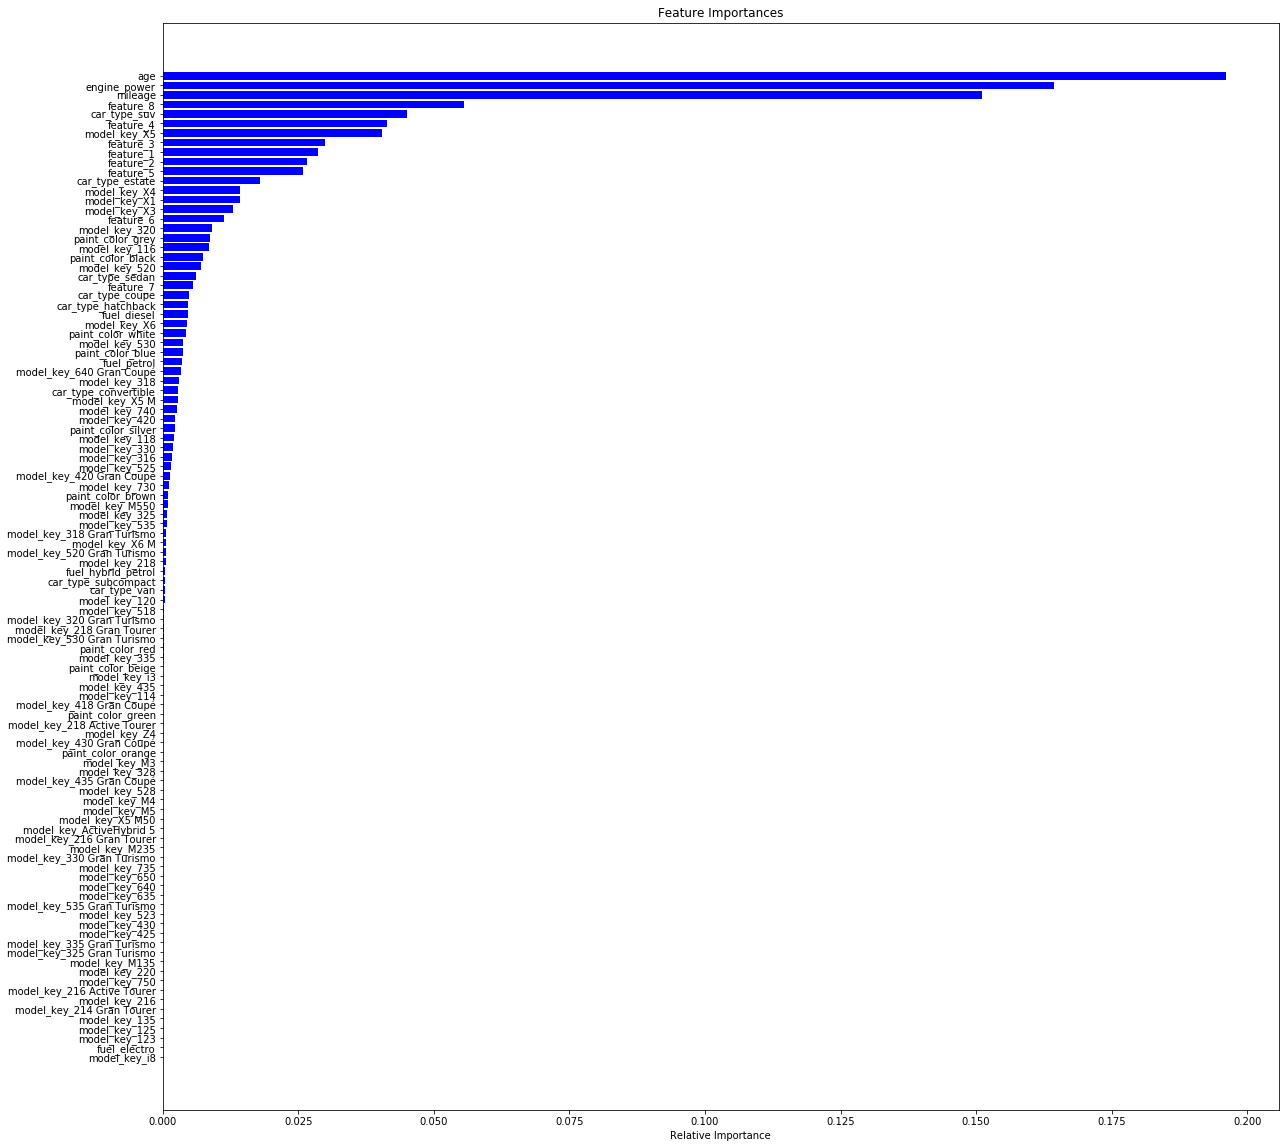

In [54]:
features = X_train.columns
importances = gb_search.best_estimator_.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(20, 20))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()